In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2614, done.
remote: Counting objects: 100% (2614/2614), done.
remote: Compressing objects: 100% (2175/2175), done.
remote: Total 2614 (delta 648), reused 1211 (delta 405), pack-reused 0
Receiving objects: 100% (2614/2614), 32.58 MiB | 18.61 MiB/s, done.
Resolving deltas: 100% (648/648), done.


# **Before continuing, Please follow the following steps:** 

# **Go to models/research/object_detection/packages/tf2/setup.py, then replace 'tf-models-official' by 'tf-models-official==2.4.0'** 


In [ ]:

# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1648391 sha256=0f9b93aca4eec2f88f73e112b38793b9d96331925d916897f25f57de142f8d2e
  Stored in directory: /tmp/pip-ephem-wheel-cache-wk8ko1g_/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.2-cp37-none-any.whl size=44011 sha256=6afa432281ee545e44440c2b23ae234b9c68201976fc8b35723fd968c66302e6
  Stored in directory: /root/.cache/pip/wheels/ee/ee/18/c466221ca6900e3efce2f4ea9c329288808679aecdcb2838d3
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=a7d45c704490537f9c25fba5892e40da527a11aa7a03a7774f56ac30115d3ea2
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for dill: filename=dill-0.3.1.1-cp37-none-any.whl size=78532 sha256=b8ef073b1769bbcc53326b3767139c85e8e124665ff3816461cb

ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.29.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.2 which is incompatible.


In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [ ]:
!wget http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet101_coco_2018_01_28.tar.gz
!tar -xvf faster_rcnn_resnet101_coco_2018_01_28.tar.gz

--2021-05-06 11:27:41--  http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet101_coco_2018_01_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.23.128, 2404:6800:4008:c02::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.23.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 593445323 (566M) [application/x-tar]
Saving to: ‘faster_rcnn_resnet101_coco_2018_01_28.tar.gz’

faster_rcnn_resnet1 100%[===================>] 565.95M  67.4MB/s    in 9.0s    

2021-05-06 11:27:51 (63.1 MB/s) - ‘faster_rcnn_resnet101_coco_2018_01_28.tar.gz’ saved [593445323/593445323]

faster_rcnn_resnet101_coco_2018_01_28/
faster_rcnn_resnet101_coco_2018_01_28/model.ckpt.index
faster_rcnn_resnet101_coco_2018_01_28/checkpoint
faster_rcnn_resnet101_coco_2018_01_28/pipeline.config
faster_rcnn_resnet101_coco_2018_01_28/model.ckpt.data-00000-of-00001
faster_rcnn_resnet101_coco_2018_01_28/model.ckpt.meta
faster_rcnn_resn

In [ ]:
PATH_TO_CKPT = "faster_rcnn_resnet101_coco_2018_01_28" + '/frozen_inference_graph.pb'

In [ ]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [ ]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.compat.v1.GraphDef()  
  with tf.compat.v2.io.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [ ]:
import sys
import itertools
import cv2
import numpy as np
from PIL import Image
from numpy import asarray
from numpy import expand_dims
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.callbacks import EarlyStopping
from keras.models import Model, Sequential
from keras.layers import Dense, Lambda
from keras.layers import Flatten, BatchNormalization
from keras.layers import Dropout
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Label names for class numbers
#pose_rep={0: 'bending',
 #1: 'fallen',
 #2: 'falling',
 #3: 'getting_up',
 #4: 'laying_down',
 #5: 'standing',
 #6: 'walking'}

In [ ]:
# Label names for class numbers
pose_rep={0: 'fallen',
 1: 'falling', 
 2: 'standing'}

In [ ]:
import glob, shutil
for file in glob.glob('/content/drive/MyDrive/FallNet/walking/*.jpg'):
  shutil.move(file, '/content/drive/MyDrive/FallNet/standing' )

In [ ]:
#train test split
!pip install split-folders

In [ ]:
import splitfolders  # or import split_folders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("/content/drive/MyDrive/FallNet", output="/content/drive/MyDrive/FallNet", seed=1337, ratio=(.8, .2), group_prefix=None) # default values

Copying files: 4010 files [00:53, 74.86 files/s]


In [ ]:
datagen = ImageDataGenerator(featurewise_center=True)
train_it = datagen.flow_from_directory('/content/drive/MyDrive/FallNet/val', batch_size = 32)
train_it.class_indices

Found 803 images belonging to 3 classes.


{'fallen': 0, 'falling': 1, 'standing': 2}

In [ ]:
!rm -rf '/content/drive/MyDrive/FallNet/train/.ipynb_checkpoints/'

In [ ]:
def define_model():
    model = ResNet50(weights='imagenet', include_top = False, input_shape=(224,224, 3), pooling='avg')
    model.trainable = False
    flat1 = Flatten()(model.layers[-1].output)
    #drop1 = Dropout(0.3)(flat1)
    class1 = Dense(64, activation='relu', kernel_regularizer='l2')(flat1)
    drop = Dropout(0.2)(class1)
    output = Dense(3, activation='softmax')(drop)
	# define new model
    model = Model(inputs=model.inputs, outputs=output)
	# compile model
    opt = Adam(lr=0.001)
    #loss = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = define_model()
model.summary()

In [ ]:
def summarize_diagnostics(history):
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')
	plt.legend()
	#filename = sys.argv[0].split('/')[-1]
	#plt.savefig(filename + '_plot.png')
	plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def run_test_harness():
	# define model
    model = define_model()
	# create data generator
    datagen = ImageDataGenerator(featurewise_center=True)
	# prepare iterator
    train_it = datagen.flow_from_directory('/content/drive/MyDrive/FallNet/train', batch_size = 32, shuffle =False)
    test_it = datagen.flow_from_directory('/content/drive/MyDrive/FallNet/val', batch_size = 32, shuffle = False)
	# fit model
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
                                  validation_data=test_it, validation_steps=len(test_it), epochs=10, verbose=1)
    # evaluate model on training set
    _, acc1 = model.evaluate_generator(train_it, steps=len(train_it), verbose=0)
    print('> %.3f' % (acc1 * 100.0))
	# evaluate model on testing set
    _, acc2 = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('> %.3f' % (acc2 * 100.0))
  # learning curves
    summarize_diagnostics(history)

    Y_pred_train = model.predict(train_it, workers = 0)
    y_pred_train = np.argmax(Y_pred_train, axis=1)
    preds = train_it.classes[train_it.index_array]
    classLabels = list(train_it.class_indices.keys())
    print('Confusion Matrix Train')
    cnf_matrix = confusion_matrix(preds, y_pred_train)
    print(plot_confusion_matrix(cnf_matrix, classes=classLabels, normalize= False,  title='Confusion matrix Train'))

    print('\n')
    
    plt.figure()
    Y_pred_test = model.predict(test_it, workers = 0)
    preds = np.argmax(Y_pred_test, axis=1)
    trueClass = test_it.classes[test_it.index_array]
    classLabels = list(test_it.class_indices.keys())
    print('Confusion Matrix Test')
    cnf_matrix1 = confusionMatrix = (confusion_matrix(y_true=trueClass,y_pred=preds))
    print(plot_confusion_matrix(cnf_matrix1, classes=classLabels, normalize= False,  title='Confusion matrix Val'))

    # Save model for later use
    tf.keras.models.save_model(model,'/content/drive/My Drive/fallingnet_testv5.h5')


Found 3207 images belonging to 3 classes.
Found 803 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/10
101/101 [==============================] - 40s 357ms/step - loss: 3.0754 - accuracy: 0.3679 - val_loss: 1.3825 - val_accuracy: 0.7572
Epoch 2/10
101/101 [==============================] - 35s 343ms/step - loss: 1.3940 - accuracy: 0.6869 - val_loss: 1.1571 - val_accuracy: 0.6961
Epoch 3/10
101/101 [==============================] - 35s 343ms/step - loss: 1.0966 - accuracy: 0.7278 - val_loss: 0.9443 - val_accuracy: 0.7584
Epoch 4/10
101/101 [==============================] - 35s 343ms/step - loss: 0.9147 - accuracy: 0.7593 - val_loss: 0.9228 - val_accuracy: 0.7248
Epoch 5/10
101/101 [==============================] - 35s 342ms/step - loss: 0.8330 - accuracy: 0.7633 - val_loss: 0.6746 - val_accuracy: 0.8269
Epoch 6/10
101/101 [==============================] - 35s 342ms/step - loss: 0.7275 - accuracy: 0.7845 - val_loss: 0.6274 - val_accuracy: 0.8182
Epoch 7/10
101/101 [==============================] - 35s 342ms/step - loss: 0.7649 - accuracy: 0.7638 - val_loss: 0.6285 - val_ac

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


> 82.632
> 81.445


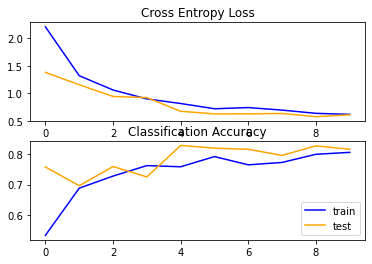

Confusion Matrix Train
Confusion matrix, without normalization
[[1003   38    0]
 [ 228  775   69]
 [  18  204  872]]
None


Confusion Matrix Test
Confusion matrix, without normalization
[[249  12   0]
 [ 54 203  11]
 [  6  66 202]]
None


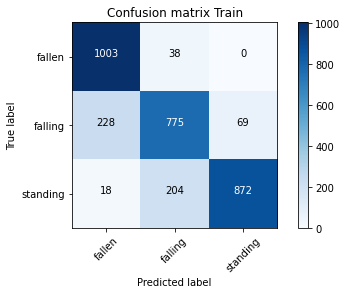

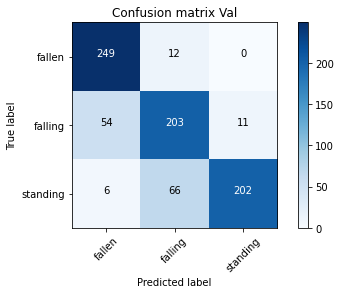

In [ ]:
run_test_harness()

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

def pose_infer(image):
  model = define_model()
  #image = load_img(image,target_size=(224, 224))
  image = img_to_array(image)
  # reshape data for the model
  image = np.resize(image, (1,224,224,3))
  # prepare the image for the Resnet model
  image = preprocess_input(image)
  yhat = model.predict(image)
  #yhat = yhat.argmax()
  return yhat


In [ ]:
import time
from scipy.ndimage.filters import gaussian_filter
import cv2
from PIL import Image
import numpy as np
from google.colab.patches import cv2_imshow


In [ ]:
from tensorflow.python.keras.backend import set_session
from tensorflow.python.keras.models import load_model



In [ ]:
def inference_on_video(filename, output_seconds=3600):
    output_filename = f"output_of_{filename}"
    codec = cv2.VideoWriter_fourcc(*'XVID')
    #codec = cv2.VideoWriter_fourcc( *"MP4V" )
    cap = cv2.VideoCapture(filename)
    framerate = round(cap.get(5),2)
    w = int(cap.get(3))
    h = int(cap.get(4))
    resolution = (w, h)

    VideoFileOutput = cv2.VideoWriter('/content/drive/MyDrive/outy.mp4', codec, framerate, resolution)  

    print('Framerate:', framerate)

    frames = 0

    with detection_graph.as_default():
        with tf.compat.v1.Session() as sess:
            model = load_model('/content/drive/My Drive/fallingnet_testv5.h5')
            while cap.isOpened() and frames <= framerate * output_seconds:

                start = time.time()
                ret, image_np = cap.read()
                if not ret:
                  break

                rgb = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)

                # Actual detection.
                ops = tf.compat.v1.get_default_graph().get_operations()
                all_tensor_names = {output.name for op in ops for output in op.outputs}
                tensor_dict = {}
                for key in [
                    'num_detections', 'detection_boxes', 'detection_scores',
                    'detection_classes', 'detection_masks'
                ]:
                  tensor_name = key + ':0'
                  if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.compat.v1.get_default_graph().get_tensor_by_name(
                        tensor_name)
                if 'detection_masks' in tensor_dict:
                  # The following processing is only for single image
                  detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                  detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                  # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                  real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                  detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                  detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                  detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                      detection_masks, detection_boxes, image_np.shape[0], image_np.shape[1])
                  detection_masks_reframed = tf.cast(
                      tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                  # Follow the convention by adding back the batch dimension
                  tensor_dict['detection_masks'] = tf.expand_dims(
                      detection_masks_reframed, 0)
                image_tensor = tf.compat.v1.get_default_graph().get_tensor_by_name('image_tensor:0')

                # Run inference
                output_dict = sess.run(tensor_dict,
                                      feed_dict={image_tensor: np.expand_dims(image_np, 0)})

                # all outputs are float32 numpy arrays, so convert types as appropriate
                output_dict['num_detections'] = int(output_dict['num_detections'][0])
                output_dict['detection_classes'] = output_dict[
                    'detection_classes'][0].astype(np.uint8)
                output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
                output_dict['detection_scores'] = output_dict['detection_scores'][0]
                if 'detection_masks' in output_dict:
                  output_dict['detection_masks'] = output_dict['detection_masks'][0]


                # Visualization of the results of a detection.
                # Cropping each picture of humans detected.
                rects = []
                for i, class_id in enumerate(output_dict['detection_classes']):
                  if class_id == 1 and output_dict['detection_scores'][i] > 0.6: # 60% Person
                    y1, x1, y2, x2 = output_dict['detection_boxes'][i]
                    x1 *= image_np.shape[1]
                    x2 *= image_np.shape[1]
                    y1 *= image_np.shape[0]
                    y2 *= image_np.shape[0]
                    rects.append([int(x1), int(y1), int(x2), int(y2)])
                    person_cropped = image_np[int(y1):int(y2), int(x1):int(x2),:]
                    person_cropped = array_to_img(person_cropped)
                    image = img_to_array(person_cropped)
                    # reshape data for the model
                    image = np.resize(image, (1,224,224,3))
                    # prepare the image for the Resnet model
                    image = preprocess_input(image)
                    pose = model.predict(image, workers = 0)

                    x1 = int(x1)
                    x2 = int(x2)
                    y1 = int(y1)
                    y2 = int(y2)

                    ### INSERT YOUR LOGIC HERE FOR EACH CROPPED PERSON ###
                    #pose = pose_infer(person_cropped) #gets pose number from model prediction
                    name=pose_rep[np.argmax(pose)]
                    cv2.rectangle(image_np,(x1,y1),(x2,y2),(0,255,0), 2)
                    image_np=cv2.putText(image_np,name,(x1,y1-10),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,255),2,cv2.LINE_AA)
                    image_np=cv2.putText(image_np,str(np.max(pose)),(x1,y1+10),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1,cv2.LINE_AA)
                    #cv2_imshow(image_np)

                VideoFileOutput.write(image_np)
                
                if frames % framerate == 0:
                  print(f'Frame {frames} ({frames/framerate :.4} seconds) Done in: {round(time.time() - start, 2)} s')
                  
                frames += 1

    cap.release()
    VideoFileOutput.release()
    print('done')

In [ ]:
inference_on_video('/content/drive/MyDrive/slip.mp4')

Framerate: 15.0
Frame 0 (0.0 seconds) Done in: 5.22 s
Frame 15 (1.0 seconds) Done in: 0.42 s
Frame 30 (2.0 seconds) Done in: 0.43 s
Frame 45 (3.0 seconds) Done in: 0.42 s
Frame 60 (4.0 seconds) Done in: 0.43 s
Frame 75 (5.0 seconds) Done in: 0.43 s


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Frame 90 (6.0 seconds) Done in: 0.45 s
Frame 105 (7.0 seconds) Done in: 0.47 s
Frame 120 (8.0 seconds) Done in: 0.47 s
Frame 135 (9.0 seconds) Done in: 0.48 s
Frame 150 (10.0 seconds) Done in: 0.46 s
Frame 165 (11.0 seconds) Done in: 0.48 s
Frame 180 (12.0 seconds) Done in: 0.46 s
Frame 195 (13.0 seconds) Done in: 0.45 s
Frame 210 (14.0 seconds) Done in: 0.45 s
Frame 225 (15.0 seconds) Done in: 0.45 s
Frame 240 (16.0 seconds) Done in: 0.45 s
Frame 255 (17.0 seconds) Done in: 0.45 s
Frame 270 (18.0 seconds) Done in: 0.47 s
Frame 285 (19.0 seconds) Done in: 0.45 s
Frame 300 (20.0 seconds) Done in: 0.46 s
Frame 315 (21.0 seconds) Done in: 0.46 s
done
